# Summer 2020 -> INSY 5378 -> Data Science
## Project work
### Team Members: Phanikrishna Karanam, Swetha Gollamudi, Amruta Joshi, Haripriya Jujjavarapu

#### Project on Text Classification 

__Objective__: Predict whether a question asked on Quora is sincere or not. 

__Dataset Summary__: Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. 

A key challenge is to weed out insincere questions by better handling toxic and divisive content. An insincere question is defined as a question intended to make a statement rather than look for helpful answers.

__Overview on this notebook__:
Used concepts and techniques learnt during the class, to build models that reasonably classify questions as “Sincere / Insincere”. 
 - Preprocessed the text data
 - Explored classification algorithms and analyzed the metrics
 - Tune hyper parameters to improve model performance
 - Model evaluation and selection of best fit model. Test against the hold out sample for generalization evaluation 

In [38]:
# Suppress warnings

import warnings

warnings.filterwarnings('ignore')

In [39]:
# change the default system directory to project location

import os

os.chdir('C:\MSBA\Fall 2020\INSY 5376 - Big Data\Project')

In [40]:
# read the input dataset and setup the x and y arrays
# we see that there are no NULL values in the data

import pandas as pd

dataset_df = pd.read_csv('Disaster Tweet Dataset.csv')
x_dataset = dataset_df.drop('target', axis=1).values
y_dataset = dataset_df['target'].values

print('Dataset shape: ', dataset_df.shape, '\n')
dataset_df.info()

Dataset shape:  (7613, 5) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [41]:
# display the head of dataset to explore the columns and values
dataset_df[['keyword','location']] = dataset_df[['keyword','location']].fillna('') 
dataset_df['input'] = dataset_df['keyword'] + ' ' + dataset_df['text']

dataset_df = dataset_df.drop(['keyword','location','text'], axis = 1)
dataset_df

,id,target,input
0,1,1,Our Deeds are the Reason of this #earthquake ...
1,4,1,Forest fire near La Ronge Sask. Canada
2,5,1,All residents asked to 'shelter in place' are...
3,6,1,"13,000 people receive #wildfires evacuation o..."
4,7,1,Just got sent this photo from Ruby #Alaska as...
...,...,...,...
7608,10869,1,Two giant cranes holding a bridge collapse in...
7609,10870,1,@aria_ahrary @TheTawniest The out of control ...
7610,10871,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. ht...
7611,10872,1,Police investigating after an e-bike collided...


In [42]:
dataset_df['input'] = dataset_df['input'].str.lower()

x_dataset = dataset_df.drop('target', axis=1).values
y_dataset = dataset_df['target'].values

dataset_df.head()

,id,target,input
0,1,1,our deeds are the reason of this #earthquake ...
1,4,1,forest fire near la ronge sask. canada
2,5,1,all residents asked to 'shelter in place' are...
3,6,1,"13,000 people receive #wildfires evacuation o..."
4,7,1,just got sent this photo from ruby #alaska as...


Below function is to display the Target counts in the dataset passed. This is to understand the class imbalance in datasets

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def target_distribution(array, data):
    ones = np.count_nonzero(array)
    zeros = len(array) - ones
    print('Target counts in {} set:'.format(data))
    print('0: ', zeros)
    print('1: ', ones)

    plt.pie([zeros, ones], labels = ['Sincere', 'Insincere'], autopct='%.1f%%')
    plt.title('Target Distribution in {}'.format(data))
    plt.show()

Target counts in dataset set:
0:  4342
1:  3271


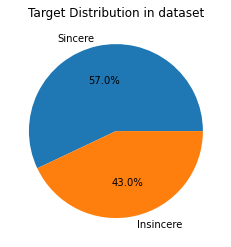

In [44]:
target_distribution(dataset_df['target'], 'dataset')

Perform a Train Test split using 80%-20% split. We are doing a stratified split based on target variable, inorder to maintain same ratio of the target class within the training and testing datasets

In [48]:
def split_data(x_dataset, y_dataset): 
    x_train, x_test, y_train, y_test = \
                        train_test_split(x_dataset, y_dataset, test_size = 0.20, stratify = y_dataset, random_state = 32)

    print('x_train shape :', x_train.shape)
    print('x_test shape  :', x_test.shape)
    print('y_train shape :', y_train.shape)
    print('y_test shape  :', y_test.shape)
    
    return(x_train, x_test, y_train, y_test)

x_train shape : (6090, 2)
x_test shape  : (1523, 2)
y_train shape : (6090,)
y_test shape  : (1523,)


Target counts in Training set:
0:  3473
1:  2617


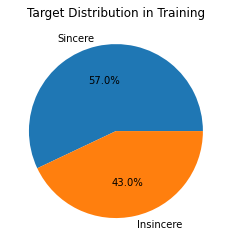

Target counts in Test set:
0:  869
1:  654


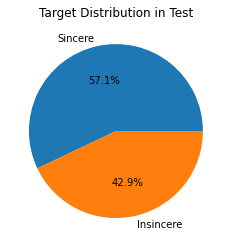

In [49]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = split_data(x_dataset, y_dataset)

print('\n')
target_distribution(y_train, 'Training')
target_distribution(y_test, 'Test')

Below function performs the preprocesing of the text array passed
 - Convert to lower case
 - Remove digits and punctuations 
 - Remove the stop words
 - Lemmatize the words to their root form 

In [50]:
def preprocess(array):
    
    # for removing punctuations and digits
    exclude = string.punctuation + string.digits
    table = str.maketrans(exclude, len(exclude) * " ")

    # for removing stopwords 
    stopwords = nltk.corpus.stopwords.words('english')

    # Instantiate Lemmatizer 
    lemmatizer = nltk.stem.WordNetLemmatizer()

    for i in range(len(array)):
        text = array[i, 1]

        # convert to lower case and remove punctuation & digits 
        text = text.lower().translate(table)

        #remove stopwords and lemmatize the word
        word_list = [lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords]

        text = " ".join(word_list)
        array[i, 1] = text

    return(array)

In [51]:
import string
import nltk

array = x_train.copy()
x_train_pp = preprocess(array)

array = x_test.copy()
x_test_pp = preprocess(array)

In [52]:
# displaying the top 10 records text column after preprocesing 

print(x_train_pp[:10, 1],'\n')
print(x_test_pp[:10, 1])

['hazard phiddleface there choking hazard dont die get'
 'obliterate watch sarah palin obliterate planned parenthood targeting minority woman \x89ûò bb sp http co dm uupqgwy'
 'weapon servicin section lurkin weapon'
 'crashed intact mh part lift odds plane glided crashed sea http co mjtn qbgos via yahoofinance hope answer'
 'drowning family mourns drowning superhero toddler rare epilepsy bradley diebold suffered hundred epileptic\x89û http co unsayjdtu'
 'danger honestly tho modibo maiga stealing living fuck im past best still danger fucktard coyi'
 'blazing dmac colorado spanish word latin origin meaning reddish colored dummy pronouncing wrong'
 'scream phone worstoverdose scream jaileens caked phone everyone look'
 'fear help win share article lifetime fear http co eh lcqkxl thanks blackinamerica growingupblack'
 'fatal winnipeg police seek witness arlington william fatal crash http co n bcf v'] 

['suicide bomber isi claim responsibility saudi mosque suicide bombing http co wpilp my

Below function is for displaying the metrics of classification model: 
 - Calculate and display the Accuracy score for the model (by comparing Actual and Predicted values)
 - Display the confusion matrix to view the TP, TN, FP, FN counts 
 - Plot the Precision Recall curve to visualize the trade-off between Precision-Recall
 - Calculate and display the Area Under Curve (AUC)

In [53]:
def report_metrics(y_test, y_pred, y_pred_prob, pred_prob = True):
    print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))
    print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))
    print('\nClassification Report:\n ', classification_report(y_test, y_pred, target_names = ['Sincere', 'Insincere']))

    if pred_prob: 
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
        area = auc(recall, precision)

        plt.plot(recall, precision, label = 'P-R curve')
        plt.legend(loc = 'lower left')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim([0.1, 1.0])
        plt.ylim([0.1, 1.1])
        plt.title('P-R curve with Area Under Curve: {:0.2f}'.format(area))
        plt.show()

Below function is to build a baseline model and report metrics of the model performance
 - Vectorize the input data using either Count or TFIDF Vectorizer (fit_transform)
 - Instantiate the model along with necessary parameters
 - Train the model on training data by performing a model.fit
 - Transform the test data using the previous vectorizer
 - Predict on the transformed test data
 - Pass the predicted target values, probabilities along with actual target values to display the metrics

In [54]:
def model_baseline(x_train_pp, y_train, x_test_pp, y_test, vectorizer_type, model_type, pred_prob = True): 

    vectorizer = vectorizer_type
    features_train = vectorizer.fit_transform(x_train_pp[:,1])
    #features_train_dense = features_train.todense()

    model = model_type
    model.fit(features_train, y_train)

    features_test = vectorizer.transform(x_test_pp[:,1])
    #features_test_dense = features_test.todense()

    y_pred = model.predict(features_test)
    
    if pred_prob:
        y_pred_prob = model.predict_proba(features_test)[:, 1]
    else: 
        y_pred_prob = 0
    
    report_metrics(y_test, y_pred, y_pred_prob, pred_prob)
    
    return(model)

Accuracy Score: 0.7826657912015759

Confusion Matrix:
 [[732 137]
 [194 460]]

Classification Report:
                precision    recall  f1-score   support

     Sincere       0.79      0.84      0.82       869
   Insincere       0.77      0.70      0.74       654

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523



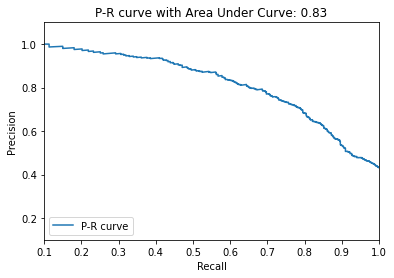

In [56]:
# Build a baseline model using Multinomial Naive Bayes Classifier (using Count Vectorizer)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, auc
from sklearn.naive_bayes import MultinomialNB

model_mnb_countvect = model_baseline(x_train_pp, y_train, x_test_pp, y_test, CountVectorizer(), MultinomialNB(alpha = 78))

Trying TfidfVectorizer instead of CountVectorizer: 
    - Although accuracy has increased, Recall and F1 are significantly impacted. We will use CountVectorizer only for MNB

Accuracy Score: 0.8076165462902167

Confusion Matrix:
 [[796  73]
 [220 434]]

Classification Report:
                precision    recall  f1-score   support

     Sincere       0.78      0.92      0.84       869
   Insincere       0.86      0.66      0.75       654

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



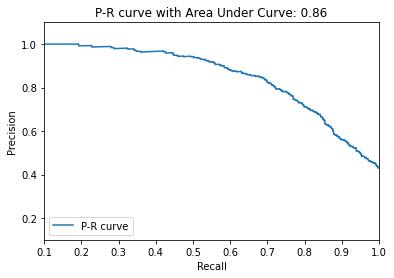

In [57]:
# Build a baseline model using Multinomial Naive Bayes Classifier (using Tfidf Vectorizer)

from sklearn.feature_extraction.text import TfidfVectorizer

model_mbn_tfidf = model_baseline(x_train_pp, y_train, x_test_pp, y_test, TfidfVectorizer(), MultinomialNB())

 - Using Logistic Regression has improved the Accuracy. When compared to MNB (with count vectorizer), although recall is less
   f1 score is same and AUC in PR curve has improved (from 0.52 to 0.59)

Accuracy Score: 0.8030203545633617

Confusion Matrix:
 [[784  85]
 [215 439]]

Classification Report:
                precision    recall  f1-score   support

     Sincere       0.78      0.90      0.84       869
   Insincere       0.84      0.67      0.75       654

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



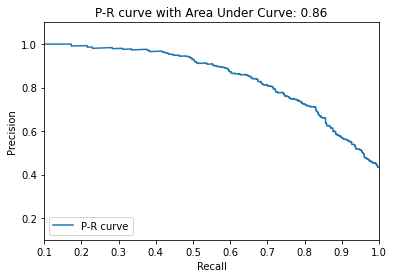

In [60]:
# Build a baseline model using Logistic Regression (using Count Vectorizer)

from sklearn.linear_model import LogisticRegression

model_lr_cv = model_baseline(x_train_pp, y_train, x_test_pp, y_test, CountVectorizer(), LogisticRegression(max_iter=1000, 
                                                                                                           C = 0.1))

 - Logistic Regression using Tfidfvectorizer
   - Overall metrics are matching MNB and Logistic Regression using CountVectorizer
   - LR using CountVectorizer has slightly better results when compared with TfidfVectrizer

Accuracy Score: 0.804333552199606

Confusion Matrix:
 [[760 109]
 [189 465]]

Classification Report:
                precision    recall  f1-score   support

     Sincere       0.80      0.87      0.84       869
   Insincere       0.81      0.71      0.76       654

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523



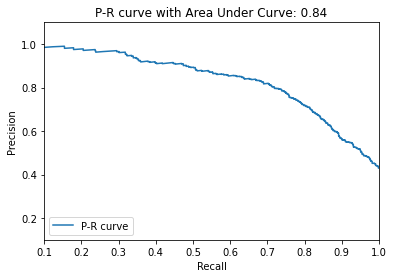

In [64]:
# Build a baseline model using Logistic Regregssion (using Tfidf Vectorizer)

model_lr_tfidf = model_baseline(x_train_pp, y_train, x_test_pp, y_test,
                                TfidfVectorizer(sublinear_tf = True), LogisticRegression(max_iter=1000))

 - Results for Linear SVC are similar to MNB and LR
 - predic_proba is not available for Linear SVC, hence PR curve is not shown

In [65]:
# Build a baseline model using Linear Support Vector Classifier (using Count Vectorizer)

from sklearn.svm import LinearSVC

model_linsvc = model_baseline(x_train_pp, y_train, x_test_pp, y_test, CountVectorizer(), 
                              LinearSVC(max_iter = 10000), pred_prob = False)

Accuracy Score: 0.7741300065659882

Confusion Matrix:
 [[728 141]
 [203 451]]

Classification Report:
                precision    recall  f1-score   support

     Sincere       0.78      0.84      0.81       869
   Insincere       0.76      0.69      0.72       654

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.77      0.77      0.77      1523



For handling Class imbalance, below are our considerations:  
    - Tried hyper parameter tuning on entire training dataset, however code is running for longer period. As Over Sampling
      increase the volume of records & Class weights doesn't reduce volume of records, we didn't opt for these techniques
    - Under Sampling -> Considering processing time and to explore hyper parameter tuning, we are chosing this method

Target counts in dataset after Under Sampling set:
0:  3271
1:  3271


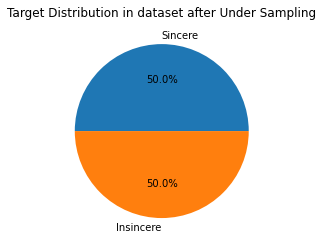

In [66]:
# Perform under sampling to match the target variable's number of 1's (Insincere) with 0's (Sincere) on dataset 

from imblearn.under_sampling import RandomUnderSampler 

sampler = RandomUnderSampler(random_state = 32)
x_resampled, y_resampled = sampler.fit_sample(x_dataset, y_dataset)

target_distribution(y_resampled, 'dataset after Under Sampling')

x_train shape : (5233, 2)
x_test shape  : (1309, 2)
y_train shape : (5233,)
y_test shape  : (1309,)


Target counts in Training after Under Sampling set:
0:  2617
1:  2616


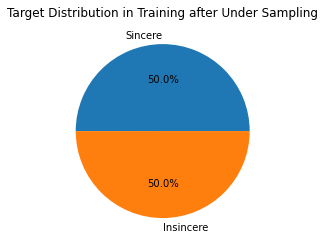

Target counts in Test after Under Sampling set:
0:  654
1:  655


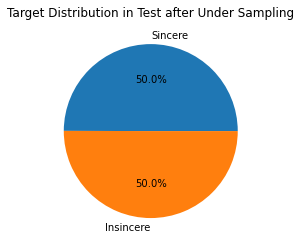

In [67]:
# Perform a train test split of the undersampled dataset. 80%-20% split and stratified on target variable 

x_train_us, x_test_us, y_train_us, y_test_us = split_data(x_resampled, y_resampled)

print('\n')
target_distribution(y_train_us, 'Training after Under Sampling')
target_distribution(y_test_us, 'Test after Under Sampling')

In [68]:
# preprocess the sampled data

array = x_train_us.copy()
x_train_us_pp = preprocess(array) 

array = x_test_us.copy()
x_test_us_pp = preprocess(array) 

In [69]:
# display the top 10 records text column, from both train and test 

print(x_train_us_pp[:10, 1],'\n')
print(x_test_us_pp[:10, 1])

['body bagging aubrey really body bagging meek'
 'rescuer unexplainable desire watch rescuer childhooddefined'
 'hail heyitsepark heavy rain hail'
 'blood wasnt big stab deep stab there like blood everwhe'
 'injured top story google dead dozen injured gaza blast near house leveled summer war\x89û http co p dz'
 'destroy beyonce nicolekidman oprah money grubbing kike need get cluei money still destroy telekinesis watch'
 'collided redcoatjackpot typical bullet collided none managed reach target curse'
 'weapon kick hendrixonfire blackcats big noob conquest mixed map weapon violated k dr limit server max'
 'explosion pyrotechnic artwork cai guo qiang explodes blossom step philadelphia http co orovzfsku'
 'bombed trying pas lax family end run ball get bombed head'] 

['sunk benaffleck respected liked talent guess stil human sunk low mr affleck'
 'sunk football back weekend sunk'
 'snowstorm lakeeffect snowstorm twill denim jacket proceeds item design go\x89û http co txtpx umqh'
 'hailstor

Function for tuning hyper parameters on various models using randomized search cross validation:
 - Build a Pipeline of estimators / transformers
 - Perform a Randomized Search 5 fold cross validation on the training dataset
 - Optimize on f1 score
 - Predict on the test dataset and pass the actual and predicted values for metrics reporting

In [95]:
def model_optimization(steps, parameters, pred_prob = True):
    
    # Create the pipeline 
    pipeline = Pipeline(steps)

    # Create the RandomizedSearchCV object: model_cv
    model_cv = RandomizedSearchCV(estimator = pipeline, param_distributions = parameters, 
                                  cv = 5, random_state = 337, scoring = 'accuracy')

    # Fit to the training set
    model_cv.fit(x_train_us_pp[:,1], y_train_us)

    # Compute and print the metrics
    print("Tuned best parameters: {}".format(model_cv.best_params_))

    # Predit on the test set using best parameters 
    y_pred = model_cv.predict(x_test_us_pp[:,1])
    
    if pred_prob:
        y_pred_prob = model_cv.predict_proba(x_test_us_pp[:,1])[:,1]
    else: 
        y_pred_prob = 0
        
    # Generate the metrics to evaluate model performance
    report_metrics(y_test_us, y_pred, y_pred_prob, pred_prob)
    
    return(model_cv)

Observations on hyper parameter tuning for Multinomial Naive Bayes: 
 - Within count vectorizer, its chosen upto Trigrams (combination of upto 3-words) 
 - Smoothing parameter alpha = 0.8 is chosen with MNB model
 - Although target distribution is of equal ratio, algorithm chose [0.94, 0.06] as priors. 
   Default is None (i.e use priors as per data)
 - With respect to baseline:
   - Accuracy has dropped from baseline of 94% to 87% 
   - Significantly improved:
     - f1 score (75% to 87%) 
     - AUC (52% to 92%) 

Tuned best parameters: {'vectorizer__ngram_range': (1, 1), 'model_mnb__alpha': 88}
Accuracy Score: 0.6990068754774638

Confusion Matrix:
 [[333 321]
 [ 73 582]]

Classification Report:
                precision    recall  f1-score   support

     Sincere       0.82      0.51      0.63       654
   Insincere       0.64      0.89      0.75       655

    accuracy                           0.70      1309
   macro avg       0.73      0.70      0.69      1309
weighted avg       0.73      0.70      0.69      1309



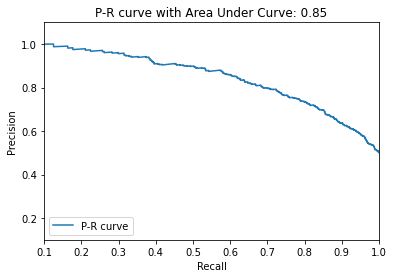

Train Acc:  0.7305560863749283
Test Acc:  0.6990068754774638


In [104]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

# Specify the pipeline steps
steps = [('vectorizer', CountVectorizer()), ('model_mnb', MultinomialNB())]

# Specify the hyperparameter space
parameters = {'vectorizer__ngram_range':[(1,1)], 
            'model_mnb__alpha': [88]}

model_mnb_hyper = model_optimization(steps, parameters)

train_acc = model_mnb_hyper.score(x_train_us_pp[:,1], y_train_us)
test_acc = model_mnb_hyper.score(x_test_us_pp[:,1], y_test_us)
print('Train Acc: ', train_acc)
print('Test Acc: ', test_acc)

In [72]:
print('Hyper Parameters tuning results from Randomized Search Cross Validation for Multinomial NB Classifier: ')
model_mnb_hyper.cv_results_

Hyper Parameters tuning results from Randomized Search Cross Validation for Multinomial NB Classifier: 


{'mean_fit_time': array([0.26007118, 0.24557018, 0.09169931, 0.3894691 , 0.41670842,
        0.43203206, 0.48758707, 0.1003346 , 0.25700445, 0.39583549]),
 'std_fit_time': array([0.01003771, 0.01008342, 0.00802414, 0.00920193, 0.04769521,
        0.02840789, 0.08197846, 0.00835892, 0.02208474, 0.04046447]),
 'mean_score_time': array([0.0318593 , 0.02978663, 0.01483364, 0.0483902 , 0.04418368,
        0.04909658, 0.05438471, 0.01954522, 0.03195014, 0.04519463]),
 'std_score_time': array([0.0065013 , 0.00380082, 0.00412493, 0.00616178, 0.00249546,
        0.01070753, 0.00755994, 0.00232623, 0.00823066, 0.00406405]),
 'param_vectorizer__ngram_range': masked_array(data=[(1, 2), (1, 2), (1, 1), (1, 3), (1, 3), (1, 3), (1, 3),
                    (1, 1), (1, 2), (1, 3)],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_model_mnb__class_prior': masked_array(data=[None, lis

Observations on hyper parameter tuning for Logistic Regression: 
 - Within count vectorizer, its chosen upto Trigrams (combination of upto 3-words) 
 - Regularization parameter C = 3.72 is chosen
   C is inverse of regularization strength and smaller values indicate stronger regularization
 - Class weights of None is chosen - both classes are weighed equally 
 - With respect to baseline: 
   - Accuracy has dropped from baseline of 95% to 88% -> 1% better than MultinomialNB
   - Significantly improved: 
     - f1 score (74% to 88%) -> 1% better than MultinomialNB
     - AUC (59% to 94%) -> 2% better than MultinomialNB

Tuned best parameters: {'vectorizer__ngram_range': (1, 3), 'model_lr__class_weight': {0: 0.06, 1: 0.94}, 'model_lr__C': 163789.3706954068}
Accuracy Score: 0.7838044308632544

Confusion Matrix:
 [[517 137]
 [146 509]]

Classification Report:
                precision    recall  f1-score   support

     Sincere       0.78      0.79      0.79       654
   Insincere       0.79      0.78      0.78       655

    accuracy                           0.78      1309
   macro avg       0.78      0.78      0.78      1309
weighted avg       0.78      0.78      0.78      1309



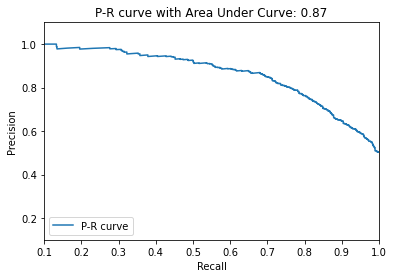

In [73]:
# Specify the pipeline steps
steps = [('vectorizer', CountVectorizer()), ('model_lr', LogisticRegression(random_state = 337, max_iter = 10000))]

# Specify the hyperparameter space
parameters = {'vectorizer__ngram_range': [(1,1),(1,2),(1,3)],               
              'model_lr__C': np.logspace(-5, 8, 15),
              'model_lr__class_weight': [None, 'balanced', {0: 0.06, 1: .94}, {0: 1, 1: 100}, {0: 100, 1: 1}]}
             
model_lr_hyper = model_optimization(steps, parameters)

In [27]:
print('Hyper Parameters tuning results from Randomized Search Cross Validation for Logistic Regression: ')
model_lr_hyper.cv_results_

Hyper Parameters tuning results from Randomized Search Cross Validation for Logistic Regression: 


{'mean_fit_time': array([  1.63486738,  12.55974617,   2.54372549,  16.31912727,
          9.97315884,   7.15128875, 187.98808522,   6.09645281,
         49.63937569, 301.96243672]),
 'std_fit_time': array([ 0.12485281,  0.27215301,  0.21441588,  0.37809277,  0.35674469,
         0.20342952, 11.49384432,  0.23475121,  1.92481713, 17.30825546]),
 'mean_score_time': array([0.33811483, 0.7743485 , 0.32793484, 0.56430988, 0.58984041,
        0.56213465, 0.83617706, 0.57347279, 0.85303636, 0.78191037]),
 'std_score_time': array([0.04456231, 0.10655381, 0.02446305, 0.01289509, 0.05568503,
        0.00318077, 0.09323368, 0.01299423, 0.14771811, 0.05761467]),
 'param_vectorizer__ngram_range': masked_array(data=[(1, 1), (1, 3), (1, 1), (1, 2), (1, 2), (1, 2), (1, 3),
                    (1, 2), (1, 3), (1, 3)],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_model_lr__class

Observations on hyper parameter tuning for Linear SVC: 
 - Within count vectorizer, its chosen upto Bigrams (combination of upto 2-words) 
 - Regularization parameter C = 0.05 is chosen
   C is inverse of regularization strength and smaller values indicate stronger regularization
 - Class weights of None is chosen - both classes are weighed equally 
 - With respect to baseline: 
   - Accuracy has dropped from baseline of 95% to 88% -> 1% better than MultinomialNB and same as LR
   - Significantly improved: 
     - f1 score (73% to 88%) -> 1% better than MultinomialNB and same as LR
     - AUC - Not Applicable as predict_proba is not present for this model

In [28]:
# Specify the pipeline steps
steps = [('vectorizer', CountVectorizer()), ('model_lsvc', LinearSVC(max_iter = 20000))]

# Specify the hyperparameter space
parameters = {'vectorizer__ngram_range': [(1,1),(1,2),(1,3)],               
              'model_lsvc__C': np.logspace(-5, 8, 15),
              'model_lsvc__class_weight': [None, 'balanced', {0: 0.06, 1: .94}, {0: 1, 1: 100}, {0: 100, 1: 1}]}
             
model_lsvc_hyper = model_optimization(steps, parameters, pred_prob = False)

Tuned best parameters: {'vectorizer__ngram_range': (1, 2), 'model_lsvc__class_weight': None, 'model_lsvc__C': 0.05179474679231213}
Accuracy Score: 0.8828115332260859

Confusion Matrix:
 [[14617  1545]
 [ 2243 13919]]

Classification Report:
                precision    recall  f1-score   support

     Sincere       0.87      0.90      0.89     16162
   Insincere       0.90      0.86      0.88     16162

    accuracy                           0.88     32324
   macro avg       0.88      0.88      0.88     32324
weighted avg       0.88      0.88      0.88     32324



In [29]:
print('Hyper Parameters tuning results from Randomized Search Cross Validation for Linear SVC: ')
model_lsvc_hyper.cv_results_

Hyper Parameters tuning results from Randomized Search Cross Validation for Linear SVC: 


{'mean_fit_time': array([  1.89693322,   8.78271971,   4.5472331 ,  13.78246884,
          6.63219557,   5.63478055, 544.50005937,   5.68686838,
         40.12712946, 663.07982421]),
 'std_fit_time': array([ 0.19491445,  0.42357294,  0.26322759,  1.84531521,  0.51931232,
         0.3719378 ,  9.51706467,  0.14504012,  6.36320343, 12.28859372]),
 'mean_score_time': array([0.31177793, 0.75201612, 0.35626531, 0.64388919, 0.63272409,
        0.6219574 , 0.76338334, 0.71309376, 0.83444495, 0.93348188]),
 'std_score_time': array([0.0075523 , 0.06342928, 0.0956736 , 0.13818627, 0.14900261,
        0.09673854, 0.04110142, 0.13514035, 0.02117514, 0.19805874]),
 'param_vectorizer__ngram_range': masked_array(data=[(1, 1), (1, 3), (1, 1), (1, 2), (1, 2), (1, 2), (1, 3),
                    (1, 2), (1, 3), (1, 3)],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_model_lsvc__cla

Use dropped records by under sampler for scoring purpose

__Note:__ only those records with Target value '0' (i.e Sincere) were dropped by under sampler 

In [76]:
resampled_array = np.hstack([x_resampled, y_resampled.reshape(-1,1)])
resampled_df = pd.DataFrame(resampled_array, columns = dataset_df.columns)

temp_df = pd.merge(dataset_df, resampled_df, how = 'left', indicator = 'true')
dropped_df = temp_df.loc[temp_df['true'] == 'left_only', temp_df.columns[:-1]]

dropped_df.shape

(1144502, 3)

Score the dropped records from under sampling, to evaluate the best fit model's performance
 - We chose Logistic Regression as the best fit model based on f1, AUC and accuracy

__Observations:__ 
 - As there are no records with Target variable as '1' (Insincere):
   - TP and FN will be zeroes, so precision and recall will be zeroes as well. Thus, AUC will not be available
 - The model accuracy is in line with previous test run 
 - Recall has improve to 95% from 88%, but thats due to the fact that we had no True Positive's in the dataset 

__Conclusion:__ It is safe to assume that Logisitic Regression is the best performing model on our data and built model is generalized 

Accuracy Score: 0.8979023190872537

Confusion Matrix:
 [[1027651  116851]
 [      0       0]]

Classification Report:
                precision    recall  f1-score   support

     Sincere       1.00      0.90      0.95   1144502
   Insincere       0.00      0.00      0.00         0

    accuracy                           0.90   1144502
   macro avg       0.50      0.45      0.47   1144502
weighted avg       1.00      0.90      0.95   1144502



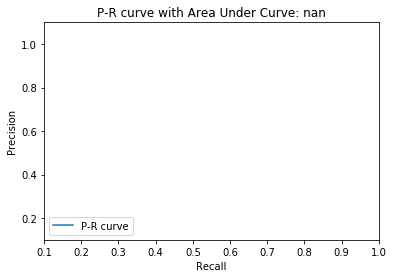

In [78]:
# Set up x and y for scoring dataset
x_score = dropped_df.drop('target', axis=1).values

# target variable is currently of type Object, converting to int64 
# This is being done so that accuracy_score works fine when it compares y_pred (which is int64) with y_score 
y_score = dropped_df['target'].astype('int64').values 

# Preprocess the x_score prior to passing it to model 
array = x_score
x_score_pp = preprocess(array)

# Use the best fit model and predict on the dropped dataset to obtain predicted and probabilities for target variable
y_pred = model_lr_hyper.predict(x_score_pp[:,1])
y_pred_prob = model_lr_hyper.predict_proba(x_score_pp[:,1])[:,1]

# Generate the metrics to evaluate model performance for generalization 
report_metrics(y_score, y_pred, y_pred_prob)

In [82]:
np.linspace(1,100,10)

array([  1.,  12.,  23.,  34.,  45.,  56.,  67.,  78.,  89., 100.])

array([0.001, 0.012, 0.023, 0.034, 0.045, 0.056, 0.067, 0.078, 0.089,
       0.1  ])